In [1]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

In [5]:
dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

In [14]:
import collections

import torch
import torch.nn as nn


class MnistNet(nn.Module):
    def __init__(self, n_channels=1):
        super(MnistNet, self).__init__()
        self.features = []
        self.initial = None
        self.classifier = []
        self.layers = collections.OrderedDict()

        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=8, kernel_size=5)
        self.features.append(self.conv1) #0
        self.layers["conv1"] = self.conv1

        self.ReLU1 = nn.ReLU(False)
        self.features.append(self.ReLU1) #1
        self.layers["ReLU1"] = self.ReLU1

        self.pool1 = nn.MaxPool2d(2, 2)
        self.features.append(self.pool1) #2
        self.layers["pool1"] = self.pool1

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.features.append(self.conv2) #3
        self.layers["conv2"] = self.conv2

        self.ReLU2 = nn.ReLU(False)
        self.features.append(self.ReLU2) #4
        self.layers["ReLU2"] = self.ReLU2

        self.pool2 = nn.MaxPool2d(2, 2)
        self.features.append(self.pool2) #5
        self.layers["pool2"] = self.pool2

        self.feature_dims = 16 * 4 * 4
        self.fc1 = nn.Linear(self.feature_dims, 120) #start=6
        self.classifier.append(self.fc1)
        self.layers["fc1"] = self.fc1

        self.fc1act = nn.ReLU(False)
        self.classifier.append(self.fc1act)
        self.layers["fc1act"] = self.fc1act

        self.fc2 = nn.Linear(120, 84)
        self.classifier.append(self.fc2)
        self.layers["fc2"] = self.fc2

        self.fc2act = nn.ReLU(False)
        self.classifier.append(self.fc2act)
        self.layers["fc2act"] = self.fc2act

        self.fc3 = nn.Linear(84, 10)
        self.classifier.append(self.fc3)
        self.layers["fc3"] = self.fc3

        self.initial_params = [
            param.clone().detach().data for param in self.parameters()
        ]

    def forward(self, x, start=0, end=10):
        if start <= 5:  # start in self.features
            for idx, layer in enumerate(self.features[start:]):
                x = layer(x)
                if idx == end:
                    return x
            x = x.view(-1, self.feature_dims)
            for idx, layer in enumerate(self.classifier):
                x = layer(x)
                if idx + 6 == end:
                    return x
        else:
            if start == 6:
                x = x.view(-1, self.feature_dims)
            for idx, layer in enumerate(self.classifier):
                if idx >= start - 6:
                    x = layer(x)
                if idx + 6 == end:
                    return x

    def get_params(self, end=10):
        params = []
        for layer in list(self.layers.values())[: end + 1]:
            params += list(layer.parameters())
        return params

    def restore_initial_params(self):
        for param, initial in zip(self.parameters(), self.initial_params):
            param.data = initial.requires_grad_(True)


class CifarNet(nn.Module):
    def __init__(self, n_channels=3):
        super(CifarNet, self).__init__()
        self.features = []
        self.initial = None
        self.classifier = []
        self.layers = collections.OrderedDict()

        self.conv11 = nn.Conv2d(
            in_channels=n_channels, out_channels=64, kernel_size=3, padding=1
        )
        self.features.append(self.conv11)
        self.layers["conv11"] = self.conv11

        self.ReLU11 = nn.ReLU(True)
        self.features.append(self.ReLU11)
        self.layers["ReLU11"] = self.ReLU11

        self.conv12 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, padding=1
        )
        self.features.append(self.conv12)
        self.layers["conv12"] = self.conv12

        self.ReLU12 = nn.ReLU(True)
        self.features.append(self.ReLU12)
        self.layers["ReLU12"] = self.ReLU12

        self.pool1 = nn.MaxPool2d(2, 2)
        self.features.append(self.pool1)
        self.layers["pool1"] = self.pool1

        self.conv21 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1
        )
        self.features.append(self.conv21)
        self.layers["conv21"] = self.conv21

        self.ReLU21 = nn.ReLU(True)
        self.features.append(self.ReLU21)
        self.layers["ReLU21"] = self.ReLU21

        self.conv22 = nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, padding=1
        )
        self.features.append(self.conv22)
        self.layers["conv22"] = self.conv22

        self.ReLU22 = nn.ReLU(True)
        self.features.append(self.ReLU22)
        self.layers["ReLU22"] = self.ReLU22

        self.pool2 = nn.MaxPool2d(2, 2)
        self.features.append(self.pool2)
        self.layers["pool2"] = self.pool2

        self.conv31 = nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, padding=1
        )
        self.features.append(self.conv31)
        self.layers["conv31"] = self.conv31

        self.ReLU31 = nn.ReLU(True)
        self.features.append(self.ReLU31)
        self.layers["ReLU31"] = self.ReLU31

        self.conv32 = nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, padding=1
        )
        self.features.append(self.conv32)
        self.layers["conv32"] = self.conv32

        self.ReLU32 = nn.ReLU(True)
        self.features.append(self.ReLU32)
        self.layers["ReLU32"] = self.ReLU32

        self.pool3 = nn.MaxPool2d(2, 2)
        self.features.append(self.pool3)
        self.layers["pool3"] = self.pool3

        self.feature_dims = 4 * 4 * 128
        self.fc1 = nn.Linear(self.feature_dims, 512)
        self.classifier.append(self.fc1)
        self.layers["fc1"] = self.fc1

        self.fc1act = nn.Sigmoid()
        self.classifier.append(self.fc1act)
        self.layers["fc1act"] = self.fc1act

        self.fc2 = nn.Linear(512, 10)
        self.classifier.append(self.fc2)
        self.layers["fc2"] = self.fc2

        self.initial_params = [param.data for param in self.parameters()]

    def forward(self, x, start=0, end=17):
        if start <= len(self.features) - 1:  # start in self.features
            for idx, layer in enumerate(self.features[start:]):
                x = layer(x)
                if idx == end:
                    return x
            x = x.view(-1, self.feature_dims)
            for idx, layer in enumerate(self.classifier):
                x = layer(x)
                if idx + 15 == end:
                    return x
        else:
            if start == 15:
                x = x.view(-1, self.feature_dims)
            for idx, layer in enumerate(self.classifier):
                if idx >= start - 15:
                    x = layer(x)
                if idx + 15 == end:
                    return x

    def get_params(self, end=17):
        params = []
        for layer in list(self.layers.values())[: end + 1]:
            params += list(layer.parameters())
        return params

    def restore_initial_params(self):
        for param, initial in zip(self.parameters(), self.initial_params):
            param.data = initial


In [2]:
import math

class DefenseLayer(torch.nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, input_dim, output_dim, U):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.empty(input_dim, output_dim), requires_grad=True)
        self.U = U

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        torch.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    def forward(self, input):
        #return input @ self.U.weight.T.detach() @ self.weight
        output = torch.matmul(torch.matmul(input, self.U.weight.T), self.weight)
        assert output.requires_grad, "Output should have requires_grad=True"
        return output

In [7]:
import torch.nn as nn

class MnistNetWithOrthogonalDefense(nn.Module):
    def __init__(self, U, n_channels=1):
        super(MnistNetWithOrthogonalDefense, self).__init__()
        self.features = []
        self.initial = None
        self.classifier = []
        self.layers = collections.OrderedDict()

        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=8, kernel_size=5)
        self.features.append(self.conv1) #0
        self.layers["conv1"] = self.conv1

        self.ReLU1 = nn.ReLU(False)
        self.features.append(self.ReLU1) #1
        self.layers["ReLU1"] = self.ReLU1

        self.pool1 = nn.MaxPool2d(2, 2)
        self.features.append(self.pool1) #2
        self.layers["pool1"] = self.pool1

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.features.append(self.conv2) #3
        self.layers["conv2"] = self.conv2

        self.ReLU2 = nn.ReLU(False)
        self.features.append(self.ReLU2) #4
        self.layers["ReLU2"] = self.ReLU2

        self.pool2 = nn.MaxPool2d(2, 2)
        self.features.append(self.pool2) #5
        self.layers["pool2"] = self.pool2

        self.feature_dims = 16 * 4 * 4
        #self.fc1 = nn.Linear(self.feature_dims, 120) #start=6
        self.fc1 = DefenseLayer(self.feature_dims, 120, U) #start=6
        self.classifier.append(self.fc1)
        self.layers["fc1"] = self.fc1

        # adjusted layers
        #self.defense = DefenseLayer(120, 120, U) #start=7
        #self.classifier.append(self.defense)
        #self.layers["defense"] = self.defense
        # end of adjusted layers

        self.fc1act = nn.ReLU(False)
        self.classifier.append(self.fc1act)
        self.layers["fc1act"] = self.fc1act

        self.fc2 = nn.Linear(120, 84)
        self.classifier.append(self.fc2)
        self.layers["fc2"] = self.fc2

        self.fc2act = nn.ReLU(False)
        self.classifier.append(self.fc2act)
        self.layers["fc2act"] = self.fc2act

        self.fc3 = nn.Linear(84, 10)
        self.classifier.append(self.fc3)
        self.layers["fc3"] = self.fc3

        self.initial_params = [
            param.clone().detach().data for param in self.parameters()
        ]

    def forward(self, x, start=0, end=10):
        if start <= 5:  # start in self.features
            for idx, layer in enumerate(self.features[start:]):
                x = layer(x)
                if idx == end:
                    return x
            x = x.view(-1, self.feature_dims)
            for idx, layer in enumerate(self.classifier):
                x = layer(x)
                if idx + 6 == end:
                    return x
        else:
            #if start >5:
            #    x = x.view(-1, self.feature_dims)
            #for idx, layer in enumerate(self.classifier):
            #    if idx >= start - 6:
            #        x = layer(x)
            #    if idx + 6 == end:
            #        return x
            if start == 6:
                x = x.view(-1, self.feature_dims)
            for idx, layer in enumerate(self.classifier):
                if idx >= start - 6:
                    x = layer(x)
                if idx + 6 == end:
                    return x

    def get_params(self, end=10):
        params = []
        for layer in list(self.layers.values())[: end + 1]:
            params += list(layer.parameters())
        return params

    def restore_initial_params(self):
        for param, initial in zip(self.parameters(), self.initial_params):
            param.data = initial.requires_grad_(True)

In [8]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import random
import numpy as np


# computes total variation for an image
def TV(x):
    batch_size = x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]
    count_h = _tensor_size(x[:, :, 1:, :])
    count_w = _tensor_size(x[:, :, :, 1:])
    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, : h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, : w_x - 1], 2).sum()
    return (h_tv / count_h + w_tv / count_w) / batch_size


def l2loss(x):
    return (x**2).mean()


def _tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]


# get random examples from a dataset
def get_random_example(set, count=1, batch_size=1):
    indices = []
    for i in range(count):
        if i not in indices:
            indices.append(random.randrange(len(set)))
    subset = torch.utils.data.Subset(set, indices)
    subsetloader = torch.utils.data.DataLoader(
        subset, batch_size=batch_size, num_workers=0, shuffle=False
    )
    return subsetloader


# get the first `count` examples of the `target` class from dataset
def get_examples_by_class(dataset, target, count=1):
    result = []
    for image, label in dataset:
        if label == target:
            if count == 1:
                return image
            result.append(image)
        if len(result) == count:
            break
    return result


def normalize(result):
    min_v = torch.min(result)
    range_v = torch.max(result) - min_v
    if range_v > 0:
        normalized = (result - min_v) / range_v
    else:
        normalized = torch.zeros(result.size())
    return normalized


def get_test_score(m1, m2, dataset, split=0):
    score = 0
    imageloader = get_random_example(dataset, count=2000)
    for image, label in imageloader:
        pred = m2(m1(image, end=split), start=split + 1)
        if torch.argmax(pred) == label.detach():
            score += 1
    return 100 * score / len(imageloader)


def display_imagelist(images, height, width):
    fig, ax = plt.subplots(1, len(images))
    for index, image in enumerate(images):
        ax[index].axis("off")
        ax[index].imshow(image.cpu().detach().reshape(height, width))
    plt.show()


def display_cifar(images):
    fig, ax = plt.subplots(1, len(images))
    for index, image in enumerate(images):
        img = torchvision.utils.make_grid(image)
        ax[index].axis("off")
        npimg = img.cpu().detach().numpy()
        ax[index].imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [9]:
U = torch.nn.utils.parametrizations.orthogonal(nn.Linear(256, 256, bias=False))

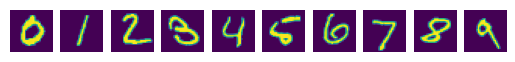

In [10]:
COUNT = 1
inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()
display_imagelist(inversion_targets, 28, 28)

In [12]:
import collections

In [15]:
split_layer = 3
client, server, clone = MnistNetWithOrthogonalDefense(U), MnistNetWithOrthogonalDefense(U), MnistNet()

In [16]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #images = images @ U.weight
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.28175005316734314 Acc: 96.38752052545156
Epoch: 1 Loss: 0.10363010317087173 Acc: 97.04595185995623
Epoch: 2 Loss: 0.07660996913909912 Acc: 98.22616407982261
Epoch: 3 Loss: 0.06553899496793747 Acc: 97.99566630552546
Epoch: 4 Loss: 0.055716436356306076 Acc: 98.06308799114555
Epoch: 5 Loss: 0.04662284255027771 Acc: 98.30693610049154
Epoch: 6 Loss: 0.04243282973766327 Acc: 98.90650628758884
Epoch: 7 Loss: 0.03692667931318283 Acc: 99.06798245614036
Epoch: 8 Loss: 0.03277343511581421 Acc: 98.57377948436643
Epoch: 9 Loss: 0.03072592057287693 Acc: 98.46238330587589


In [17]:
import numpy as np
import torch
from torchvision import transforms, datasets


def model_inversion_stealing(
    clone_model,
    split_layer,
    target,
    input_size,
    lambda_tv=0.1,
    lambda_l2=1,
    main_iters=1000,
    input_iters=100,
    model_iters=100,
):
    x_pred = torch.empty(input_size).fill_(0.5).requires_grad_(True)
    input_opt = torch.optim.Adam([x_pred], lr=0.001, amsgrad=True)
    model_opt = torch.optim.Adam(clone_model.parameters(), lr=0.001, amsgrad=True)
    mse = torch.nn.MSELoss()

    for main_iter in range(main_iters):
        for input_iter in range(input_iters):
            input_opt.zero_grad()
            pred = clone_model(x_pred, end=split_layer)
            loss = (
                mse(pred, target) + lambda_tv * TV(x_pred) + lambda_l2 * l2loss(x_pred)
            )
            loss.backward(retain_graph=True)
            input_opt.step()
        for model_iter in range(model_iters):
            model_opt.zero_grad()
            pred = clone_model(x_pred, end=split_layer)
            loss = mse(pred, target)
            loss.backward(retain_graph=True)
            model_opt.step()

    return x_pred.detach()

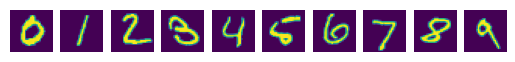

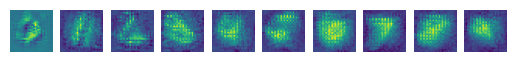

In [18]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    #target = target @ U.weight
    client_out = client(target, end=split_layer)

    # perform the attack
    result = model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)